# 금융 시계열 ARCH

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
import pmdarima as pm # Auto ARIMA 모델

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ap = pd.read_csv('./data/AirPassengers.csv')
ap.drop('Month', axis = 1, inplace = True)

In [3]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


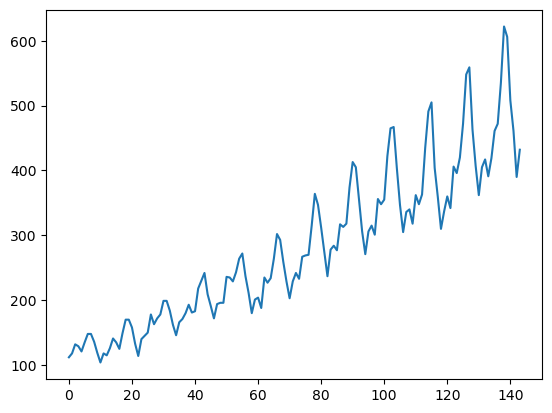

In [4]:
plt.plot(ap)
plt.show()

In [5]:
# np.log를 통해서 log transformation
ap_transformed = np.log(ap)

In [6]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


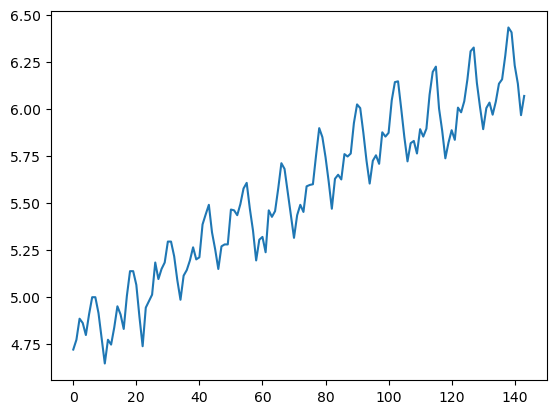

In [7]:
plt.plot(ap_transformed)
plt.show()

[]

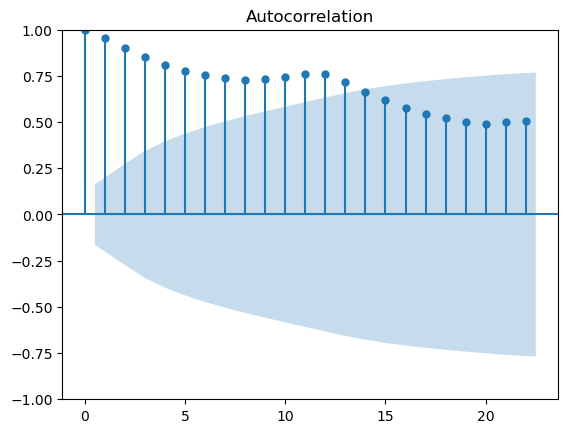

In [8]:
plot_acf(ap_transformed) # acf plot, 점차 감소하는 모양새를 지니고 있음
plt.plot()

[]

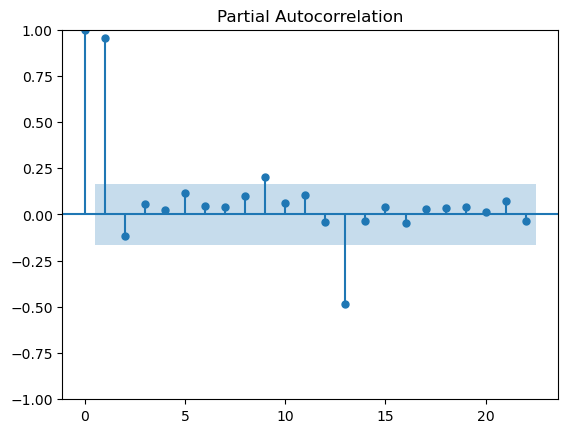

In [9]:
plot_pacf(ap_transformed) # pacf plot, lag 2까지 유의미한 결과를 보임
plt.plot()

In [10]:
# 차분
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()

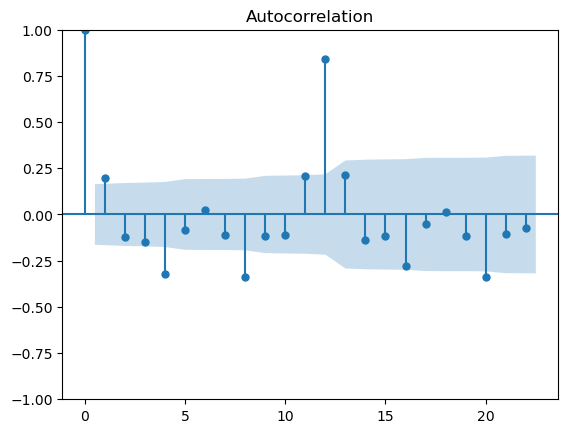

In [11]:
plot_acf(ap_diff) # lag 1과 lag 12에서 유의미한 lag가 포착됨
plt.plot()
plt.show()

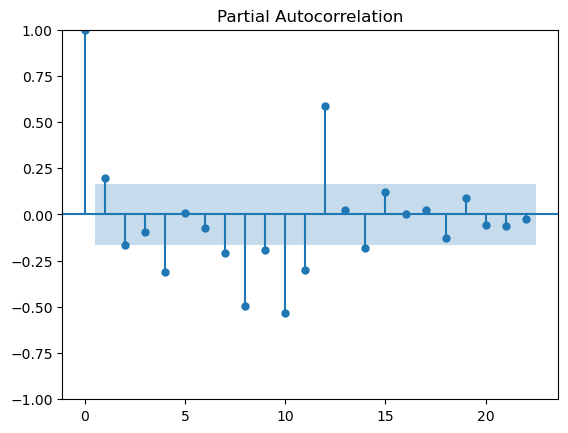

In [12]:
plot_pacf(ap_diff) # lag 1, lag 8~12쯤에서 유의미한 lag가 포착됨
plt.plot()
plt.show()

- acf와 pacf에서 n = 12 즈음에서 유의미한 상관관계 - 계절성 성분으로 추측

In [13]:
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed[train_size:]

In [28]:
# AutoARIMA
# seasonal = True, max_D(계절차분) = 12
model = pm.AutoARIMA(seasonal=True, suppress_warnings=True, trace=True, max_D=12) 
res = model.fit(ap_transformed_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-213.695, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-216.549, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-216.027, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-219.962, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-200.633, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-219.180, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-198.633, T

In [29]:
# confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) 

# 아래의 코드 결과값을 서로 비교 분석해봅시다.
print(preds.shape) 
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))

(29,)
<class 'pandas.core.series.Series'>
--------------------------------------------------------------------------------
29
<class 'int'>


In [30]:
print('--'*40)
print(preds)
print('--'*40)
print(conf_int)

--------------------------------------------------------------------------------
115    6.204146
116    6.145972
117    6.091027
118    6.045468
119    6.040403
120    6.055360
121    6.086055
122    6.115547
123    6.138634
124    6.153128
125    6.161230
126    6.166916
127    6.172955
128    6.181210
129    6.191649
130    6.203610
131    6.216042
132    6.228205
133    6.239756
134    6.250725
135    6.261354
136    6.271904
137    6.282560
138    6.293388
139    6.304362
140    6.315412
141    6.326470
142    6.337492
143    6.348467
dtype: float64
--------------------------------------------------------------------------------
[[6.037346   6.37094643]
 [5.91295177 6.37899279]
 [5.84192241 6.3401312 ]
 [5.79215474 6.29878125]
 [5.78601514 6.29479029]
 [5.79935769 6.31136233]
 [5.82787896 6.34423012]
 [5.85709056 6.37400373]
 [5.88015759 6.39710969]
 [5.89418798 6.41206759]
 [5.90157539 6.42088542]
 [5.9067206  6.42711072]
 [5.91247224 6.43343848]
 [5.92062098 6.44179962]
 [5.93101

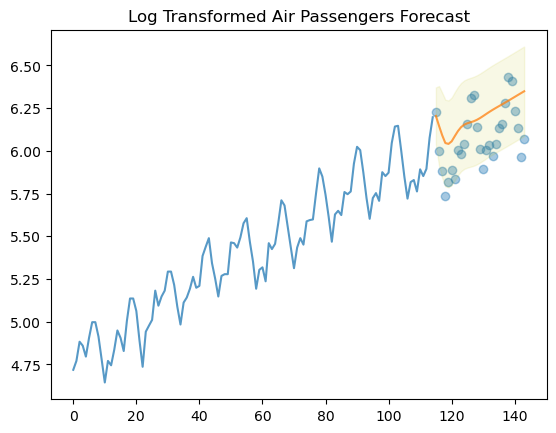

In [31]:
# 예측 성능을 시각화 
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성 (month)
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # AutoARIMA의 예측값 시각화
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test, 
            alpha=0.4, marker='o')  # 3 test data의 y값(지도 학습의 target)을 산점도(scatter plot)로 생성
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='y') # 2, 3번의 분포에 해당하는 구간 시각화
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

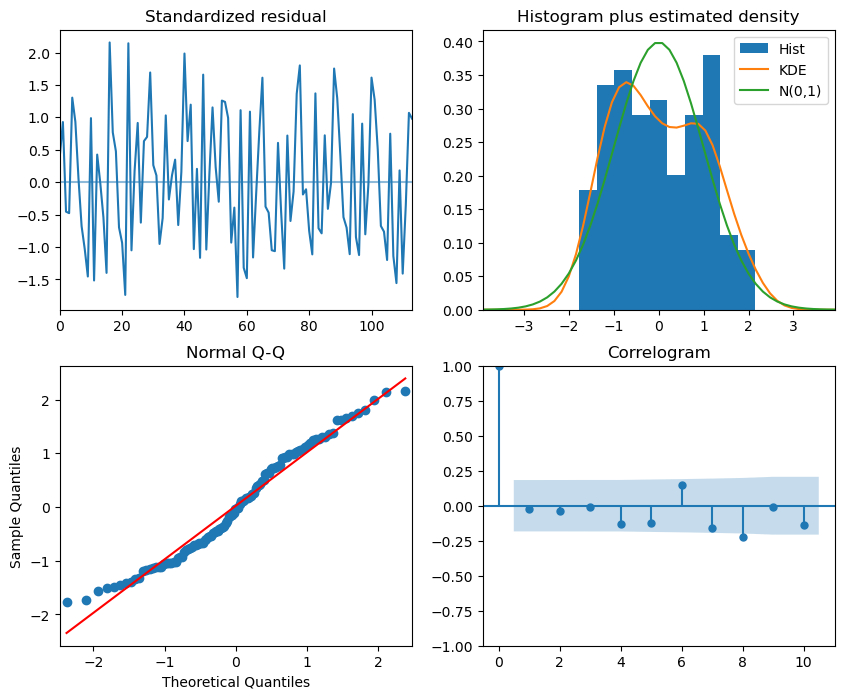

In [32]:
res.model_.plot_diagnostics(figsize=(10,8))
plt.show()

In [33]:
# AutoARIMA
# seasonal = True, max_D(계절차분) = 12
model = pm.AutoARIMA(seasonal=True, suppress_warnings=True, trace=True, m=12) 
res = model.fit(ap_transformed_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-371.497, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-375.727, Time=0.42 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-348.729, Time=0.20 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-373.728, Time=1.22 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-367.474, Time=0.53 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-371.832, Time=1.50 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-376.914, Time=0.38 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-348.813, Time=0.25 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-373.207, Time=0.53 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-374.919, Time=0.93 sec
 ARIMA(1,0,2)(1,1,0

In [35]:
# confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) 

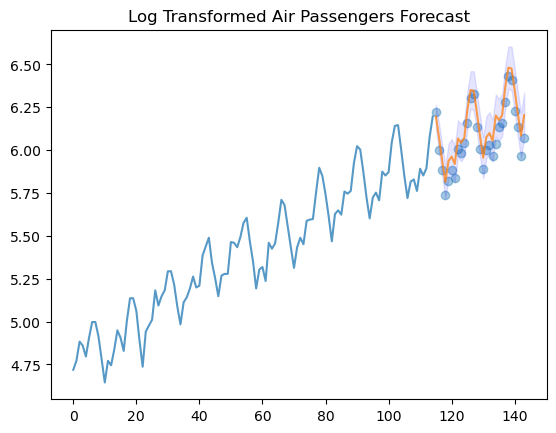

In [37]:
# 예측 성능을 시각화 
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성 (month)
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # AutoARIMA의 예측값 시각화
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test, 
            alpha=0.4, marker='o')  # 3 test data의 y값(지도 학습의 target)을 산점도(scatter plot)로 생성
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 2, 3번의 분포에 해당하는 구간 시각화
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

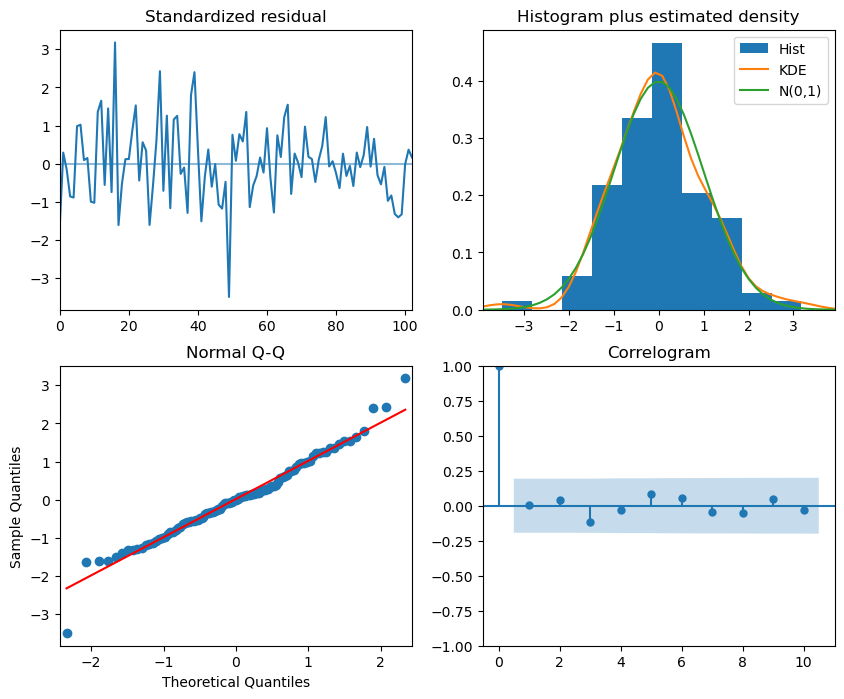

In [38]:
res.model_.plot_diagnostics(figsize=(10,8))
plt.show()

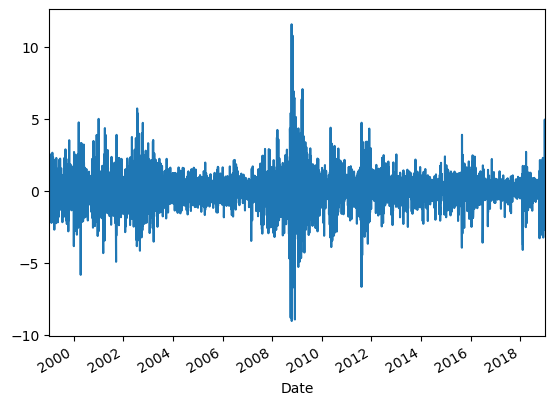

In [29]:
import datetime as dt 
import arch.data.sp500 # S&P 500 데이터셋

# 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) # start date
en = dt.datetime(2022, 1, 1) # end date
data = arch.data.sp500.load() # s&p 500 데이터 불러오기
market = data["Adj Close"] # 종가만 활용
returns = 100 * market.pct_change().dropna() # return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한 
plt.show()

In [42]:
from arch import arch_model

am = arch_model(returns) # return을 arch모델에 적합
res = am.fit(update_freq=5)

# 지표를 통한 결과 확인
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.276671700198
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482731
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476989048
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Thu, Sep 11 2025   Df Residuals:                     5029
Time:          

- 다양한 결과가 제시되어있으나, 수업때 배웠던 p-value, AIC, BIC위주로 내용을 파악
- 아래에 있는 volatility model을 보면 alpha[1], Beta[1]은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 95%에서 이들이 유의미함을 도출

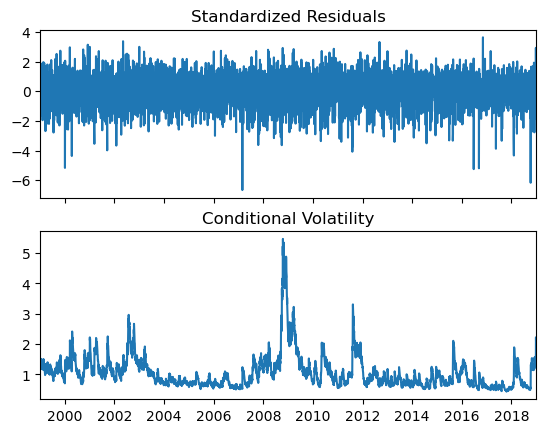

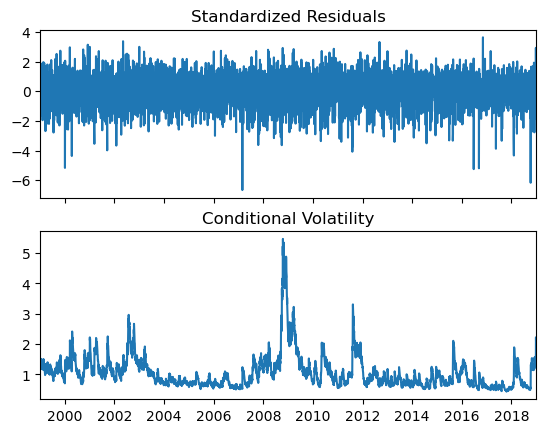

In [43]:
res.plot()

- 모델 적합 후 남은 잔차(Residual)와 포착한 조건부 변동성(conditional volatility)을 시각적으로 확인